In [3]:
!!pip install wordcloud

['Collecting wordcloud',
 '  Downloading wordcloud-1.9.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)',
 'Requirement already satisfied: numpy>=1.6.1 in /opt/conda/lib/python3.12/site-packages (from wordcloud) (1.26.4)',
 'Requirement already satisfied: pillow in /opt/conda/lib/python3.12/site-packages (from wordcloud) (11.3.0)',
 'Requirement already satisfied: matplotlib in /opt/conda/lib/python3.12/site-packages (from wordcloud) (3.10.3)',
 'Requirement already satisfied: contourpy>=1.0.1 in /opt/conda/lib/python3.12/site-packages (from matplotlib->wordcloud) (1.3.2)',
 'Requirement already satisfied: cycler>=0.10 in /opt/conda/lib/python3.12/site-packages (from matplotlib->wordcloud) (0.12.1)',
 'Requirement already satisfied: fonttools>=4.22.0 in /opt/conda/lib/python3.12/site-packages (from matplotlib->wordcloud) (4.58.5)',
 'Requirement already satisfied: kiwisolver>=1.3.1 in /opt/conda/lib/python3.12/site-packages (from matplotlib->wordcloud) (1.

# Sentiment Analysis on Product Reviews

Below are detailed step-by-step instructions for performing **Sentiment Analysis on Product Reviews using Amazon SageMaker**. The goal is to train a model to classify customer reviews as positive or negative, using a public dataset, preprocessing the text, training with a pre-built algorithm (e.g., BlazingText or XGBoost), and deploying the model as a real-time endpoint.

In [4]:
import os
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.estimator import Estimator
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer
from sklearn.metrics import accuracy_score, classification_report

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Download the IMDB dataset

Download dataset from http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz  

## Load Dataset

The IMDB dataset has a folder structure with *pos* and *neg* directories containing text files.

In [5]:
def load_imdb_data(path):
    reviews = []
    labels = []
    for label in ['pos', 'neg']:
        folder = os.path.join(path, label)
        for filename in os.listdir(folder):
            with open(os.path.join(folder, filename), 'r', encoding='utf-8') as file:
                reviews.append(file.read())
                labels.append(1 if label == 'pos' else 0) # Label each review based on folder structure
    return pd.DataFrame({'review': reviews, 'label': labels})

train_data = load_imdb_data("aclImdb/train")
train_data.head()

,review,label
0,Zentropa has much in common with The Third Man...,1
1,Zentropa is the most original movie I've seen ...,1
2,Lars Von Trier is never backward in trying out...,1
3,*Contains spoilers due to me having to describ...,1
4,That was the first thing that sprang to mind a...,1


## Preprocess Text Data

In [6]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # Join tokens back to string
    return ' '.join(tokens)

# Apply text preprocessing
train_data['cleaned_review'] = train_data['review'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## EDA

<Axes: xlabel='label'>

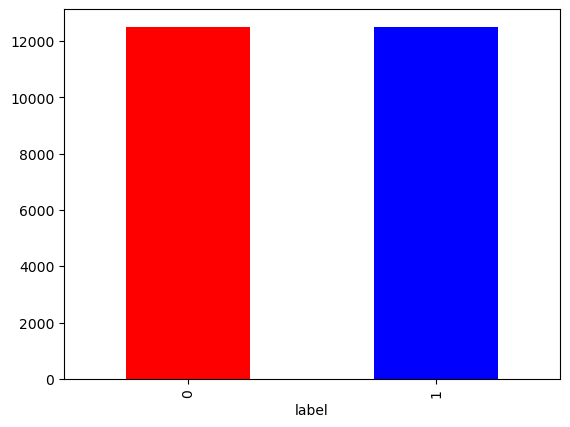

In [33]:
# Show training data count each class
train_data.groupby("label").count()["cleaned_review"].plot.bar(color=['red', 'blue'])

In [8]:
pos_text = train_data[train_data['label']==1]["cleaned_review"].tolist()
neg_text = train_data[train_data['label']==0]["cleaned_review"].tolist()
wordcloud_pos = WordCloud(width=800, height=400).generate(" ".join(pos_text))
wordcloud_neg = WordCloud(width=800, height=400).generate(" ".join(neg_text))

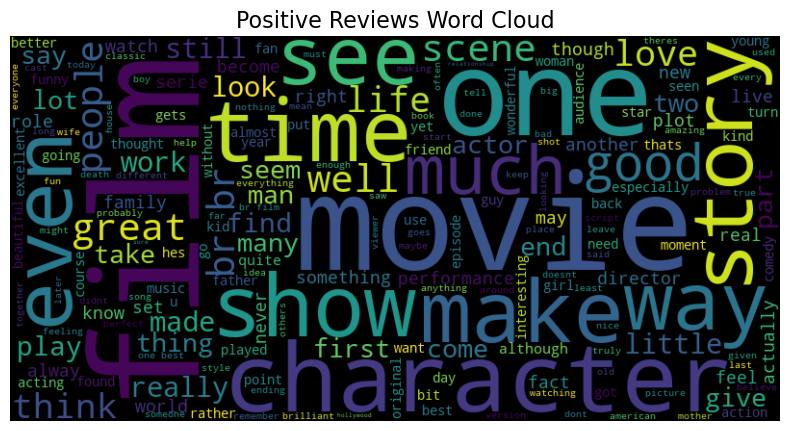

In [9]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.title("Positive Reviews Word Cloud", fontsize=16)
plt.axis("off")
plt.show()

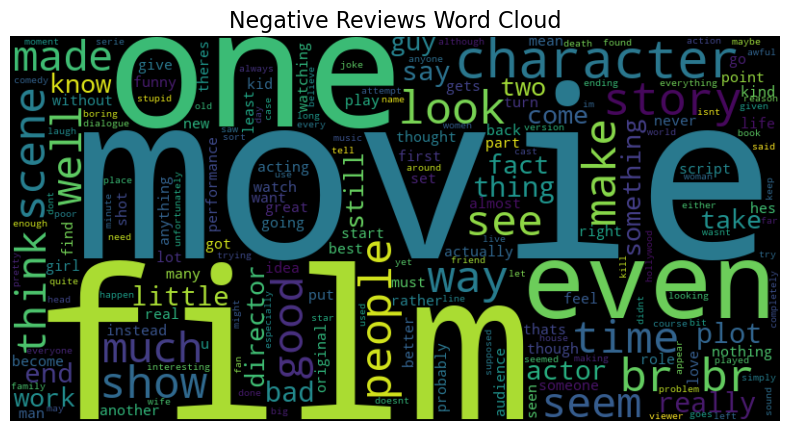

In [10]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.title("Negative Reviews Word Cloud", fontsize=16)
plt.axis("off")
plt.show()

## Prepare Data for BlazingText

Amazon SageMaker BlazingText is a built-in algorithm for fast and scalable text classification and word embedding tasks. It's optimized for high performance and is based on the popular fastText library developed by Facebook.

In [11]:
def format_for_blazingtext(df, text_col, label_col, output_file):
    with open(output_file, 'w', encoding='utf-8') as f:
        for _, row in df.iterrows():
            label = '__label__positive' if row[label_col] == 1 else '__label__negative'
            f.write(f"{label} {row[text_col]}\n")

format_for_blazingtext(train_data, 'cleaned_review', 'label', 'train.txt')

## Prepare Test Data

In [19]:
test_data = load_imdb_data('aclImdb/test')
test_data['cleaned_review'] = test_data['review'].apply(preprocess_text)
format_for_blazingtext(test_data, 'cleaned_review', 'label', 'test.txt')

## Upload Data to S3

In [12]:
s3 = boto3.client('s3')
bucket = 'sagemaker'  # Replace with your S3 bucket name
prefix = 'sentiment-analysis/data'
s3.upload_file('train.txt', bucket, f'{prefix}/train.txt')

train_s3_path = f's3://{bucket}/{prefix}/train.txt'

s3.upload_file('test.txt', bucket, f'{prefix}/test.txt')
test_s3_path = f's3://{bucket}/{prefix}/test.txt'

## Train the Model

Use BlazingText for text classification, as it’s optimized for NLP tasks like sentiment analysis.

In [21]:
role = get_execution_role()
blazingtext_image = sagemaker.image_uris.retrieve(
    framework='blazingtext',
    region=boto3.Session().region_name
)

estimator = Estimator(
    image_uri=blazingtext_image,
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    input_mode="File",
    max_run=360000,
    hyperparameters={
        'mode': 'supervised',
        'epochs': 10,
        'min_count': 2,
        'early_stopping': True,
        'patience': 4,
        'min_epochs': 5,
        'word_ngrams': 2
    },
    output_path=f's3://{bucket}/sentiment-analysis/output'
)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [22]:
# Start training
estimator.fit({'train': train_s3_path, 'validation': test_s3_path})

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: blazingtext-2025-07-21-07-57-52-740


2025-07-21 07:57:55 Starting - Starting the training job...
2025-07-21 07:58:25 Downloading - Downloading input data...
2025-07-21 07:58:51 Downloading - Downloading the training image...
2025-07-21 07:59:01 Training - Training image download completed. Training in progress.Arguments: train
[07/21/2025 07:59:16 WARNING 139823969814336] Loggers have already been setup.
[07/21/2025 07:59:16 WARNING 139823969814336] Loggers have already been setup.
/opt/amazon/python3.8/lib/python3.8/subprocess.py:848: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)
[07/21/2025 07:59:16 INFO 139823969814336] nvidia-smi took: 0.025180578231811523 secs to identify 0 gpus
[07/21/2025 07:59:16 INFO 139823969814336] Running single machine CPU BlazingText training using supervised mode.
Number of CPU sockets found in instance is  1
[07/21/2025 07:59:16 INFO 139823969814336] Processing /opt/ml/input/

## Deploy as Real Time Endpoint

In [23]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    endpoint_name='sentiment-analysis-endpoint-20250719'
)

INFO:sagemaker:Creating model with name: blazingtext-2025-07-21-08-02-21-975
INFO:sagemaker:Creating endpoint-config with name sentiment-analysis-endpoint-20250719
INFO:sagemaker:Creating endpoint with name sentiment-analysis-endpoint-20250719


----!

In [26]:
# Test the Endpoint
predictor.serializer = JSONSerializer()
predictor.deserializer = JSONDeserializer()

sample_review = preprocess_text("This product is amazing and works perfectly!")
payload = {"instances": [sample_review]}
response = predictor.predict(payload)
print(response)

[{'label': ['__label__positive'], 'prob': [1.0000100135803223]}]


In [27]:
sample_review = preprocess_text("i'm gonna give this 1 star")
payload = {"instances": [sample_review]}
response = predictor.predict(payload)
print(response)

[{'label': ['__label__negative'], 'prob': [0.9994617104530334]}]


## Clean Up

Delete the SageMaker endpoint to avoid ongoing charges

In [30]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: sentiment-analysis-endpoint-20250719
INFO:sagemaker:Deleting endpoint with name: sentiment-analysis-endpoint-20250719


In [31]:
# Additional cleanup, delete model output on S3 too
response = s3.list_objects_v2(Bucket=bucket, Prefix='sentiment-analysis/output')

# Check if any objects were found
if 'Contents' in response:
    # Delete all found objects
    delete_keys = [{'Key': obj['Key']} for obj in response['Contents']]

    s3.delete_objects(
        Bucket=bucket,
        Delete={'Objects': delete_keys}
    )
    print(f"Deleted {len(delete_keys)} objects from {bucket}/{prefix}")
else:
    print("No objects found under the specified prefix.")

Deleted 6 objects from edel-sagemaker/sentiment-analysis/data


## Reference

**Large Movie Review Dataset** https://ai.stanford.edu/~amaas/data/sentiment/

**Text Classification using SageMaker BlazingText** https://amazon-sagemaker-examples-anve.readthedocs.io/en/latest/introduction_to_amazon_algorithms/blazingtext_text_classification_dbpedia/blazingtext_text_classification_dbpedia.html  

**BlazingText algorithm** https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html  